In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

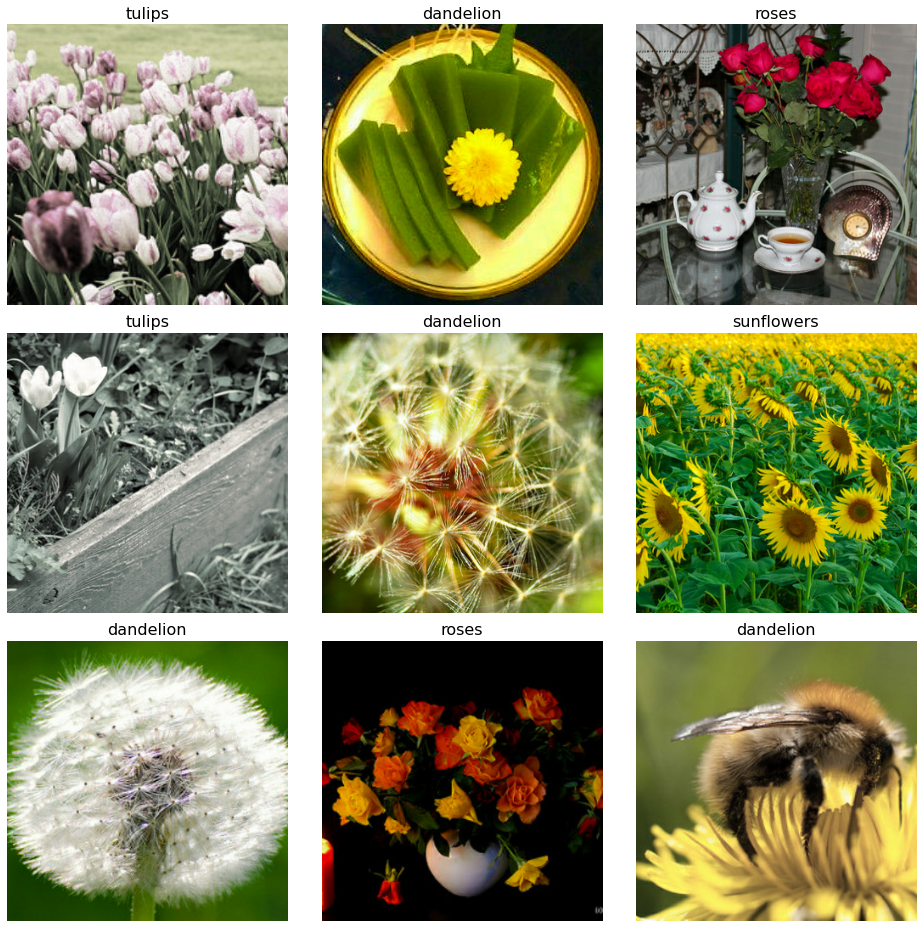

In [2]:
import tensorflow as tf
import re
import numpy as np
from matplotlib import pyplot as plt

#####
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [331, 331]

batch_size = 16 * tpu_strategy.num_replicas_in_sync

gcs_pattern = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
validation_split = 0.2
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]
        
def parse_tfrecord(example):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [5])
  return image_tensor, one_hot_class

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_training_dataset():
  dataset = load_dataset(train_fns)

  # 数据增强，通过flip increase和decrease图像饱和度  生成一些补充训练图片Create some additional training images by randomly flipping and
  # increasing/decreasing the saturation of images in the training set. 
  def data_augment(image, one_hot_class):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

  # Prefetch the next batch while training (autotune prefetch buffer size).
  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO) 

training_dataset = get_training_dataset()
validation_dataset = load_dataset(validation_fns).batch(batch_size).prefetch(AUTO)

#####
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  
# If model is provided, use it to generate predictions.
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(training_dataset, 9)

#####
# Re-run this cell to show a new batch of images
images, classes = next(training_viz_iterator)
class_idxs = np.argmax(classes, axis=-1) # transform from one-hot array to class number
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)

## Model


In [3]:
#weights='imagenet', .applications函数参数加入后为imagenet权重参与训练，不加表示不参与训练
def create_model():
  pretrained_model = tf.keras.applications.Xception(include_top=False,input_shape=[*IMAGE_SIZE, 3], )
  #pretrained_model = tf.keras.applications.ResNet50(include_top=False,input_shape=[*IMAGE_SIZE, 3], )
  pretrained_model.trainable = True # 基础模型是否参与训练 False为冻结基础模型参数不参加训练
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 11, 11, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
batch_normalization_5 (Batch (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________

## Training

In [4]:
def count_data_items(filenames):
  # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)

n_train = count_data_items(train_fns)
n_valid = count_data_items(validation_fns)
train_steps = count_data_items(train_fns) // batch_size
print("TRAINING IMAGES: ", n_train, ", STEPS PER EPOCH: ", train_steps)
print("VALIDATION IMAGES: ", n_valid)

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680


Learning rate per epoch:


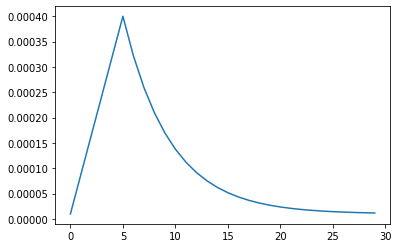

In [5]:
EPOCHS = 30

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [6]:
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=train_steps, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
23/23 [==============================] - 59s 684ms/step - loss: 2.2580 - accuracy: 0.1842 - val_loss: 1.6120 - val_accuracy: 0.1735
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
23/23 [==============================] - 7s 316ms/step - loss: 1.7356 - accuracy: 0.3218 - val_loss: 1.4824 - val_accuracy: 0.4412
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
23/23 [==============================] - 7s 322ms/step - loss: 1.1306 - accuracy: 0.5649 - val_loss: 1.3216 - val_accuracy: 0.6603
Epoch 4/30

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
23/23 [==============================] - 7s 323ms/step - loss: 0.8167 - accuracy: 0.7035 - val_loss: 1.1463 - val_accuracy: 0.7882
Epoch 5/30

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
23/23 [==============================] - 7s 321ms/step - loss: 0

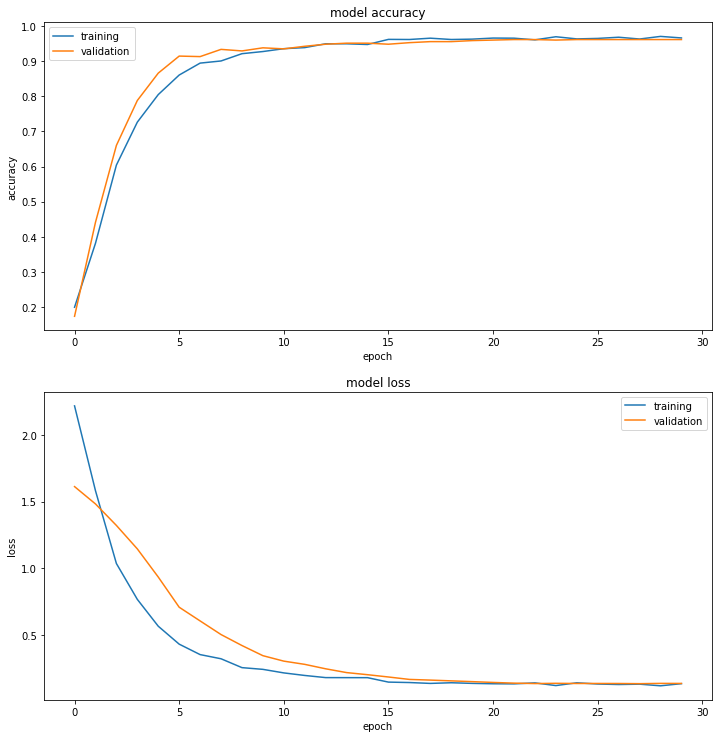

In [7]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

##Predictions

In [8]:
def flower_title(label, prediction):
  # Both prediction (probabilities) and label (one-hot) are arrays with one item per class.
  class_idx = np.argmax(label, axis=-1)
  prediction_idx = np.argmax(prediction, axis=-1)
  if class_idx == prediction_idx:
    return f'{CLASSES[prediction_idx]} [correct]', 'black'
  else:
    return f'{CLASSES[prediction_idx]} [incorrect, should be {CLASSES[class_idx]}]', 'red'

def get_titles(images, labels, model):
  predictions = model.predict(images)
  titles, colors = [], []
  for label, prediction in zip(classes, predictions):
    title, color = flower_title(label, prediction)
    titles.append(title)
    colors.append(color)
  return titles, colors

validation_viz_iterator = get_dataset_iterator(validation_dataset, 9)

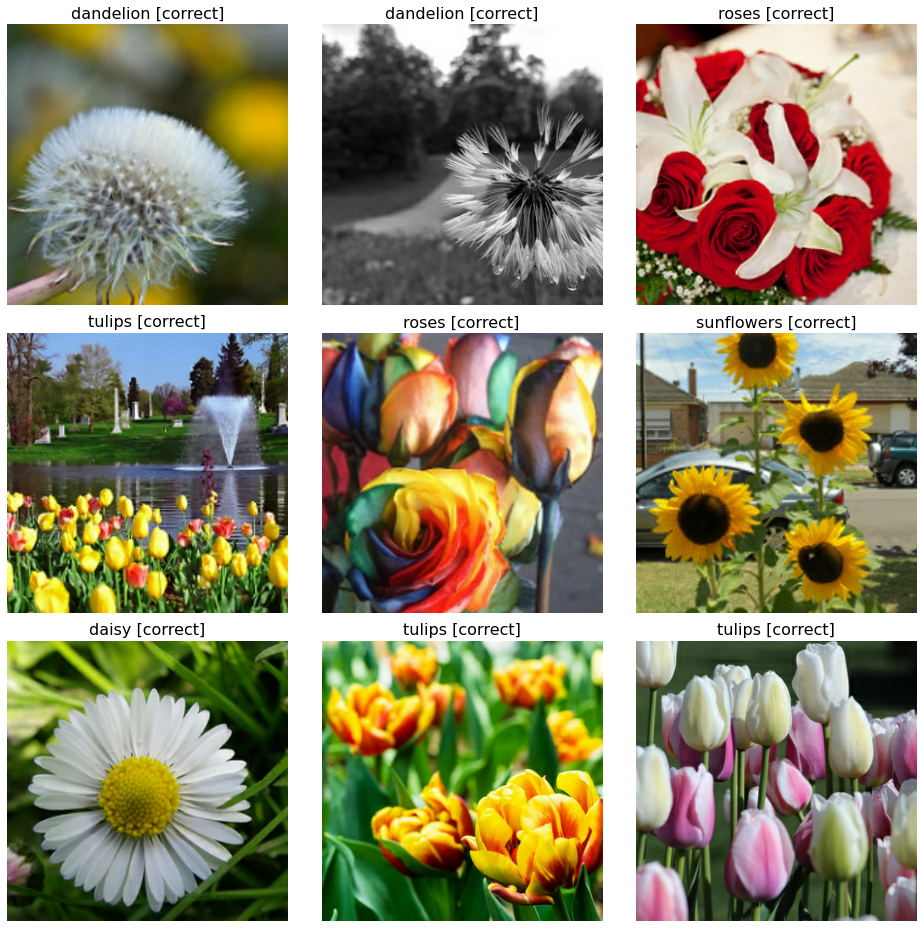

In [9]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, model)
display_nine_flowers(images, titles, colors)

In [10]:
# We can save our model with:
model.save('model.h5')
# and reload it with:
reloaded_model = tf.keras.models.load_model('model.h5')

## Save and re-loading trained model

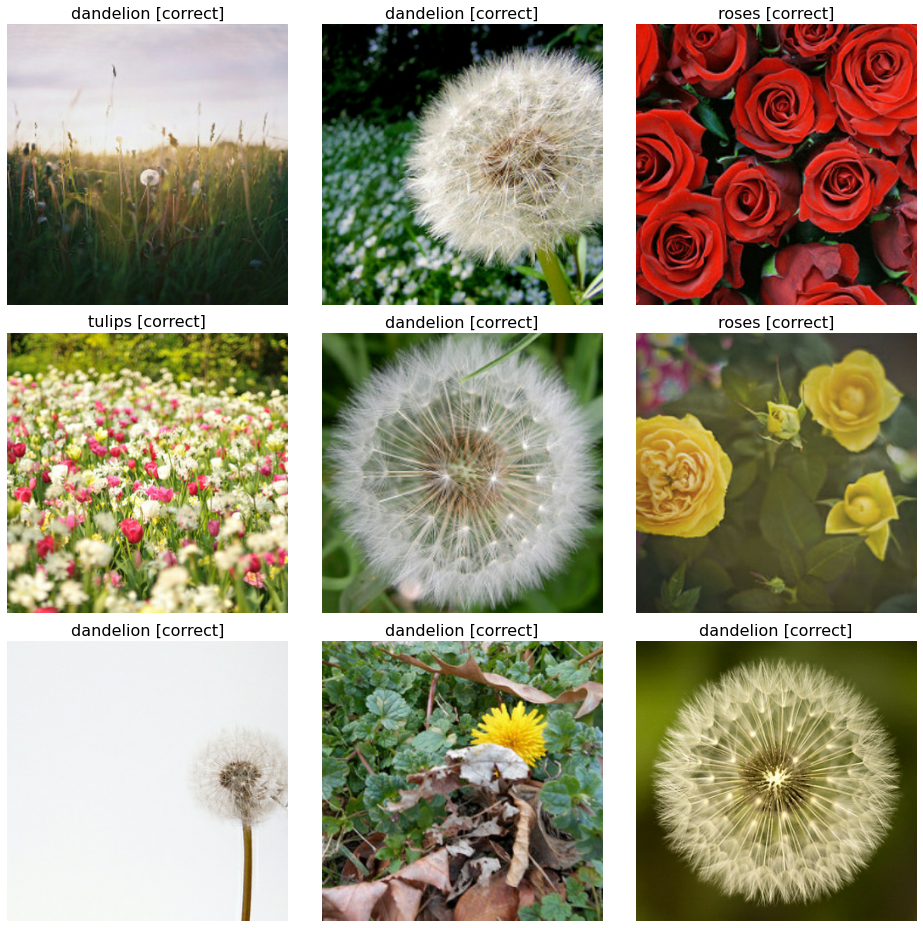

In [11]:
# Re-run this cell to show a new batch of images
images, classes = next(validation_viz_iterator)
titles, colors = get_titles(images, classes, reloaded_model)
display_nine_flowers(images, titles, colors)